Modeling Decisons: 

Non-normal features suggests decision tree model <br>
Bin rain into low medium high categorical variable, still seems like an extremely weak predictor<br>
Drop Jan / Feb data because of construction <br>
DBT appears pretty correlated with all UTCs, maybe unnesscary <br>
Impute dockability / reliability, is this related to so many zeros...definitely a problem Sarah says filter by both
this variable <br>
Very low r2 on test set, perhaps random forest regress not good model<br>

Decided to see if this data works better as a classification problem, with what appears to be more impressive results untuned rf classifier and logistic regress<br>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

In [19]:
def get_data():
    route1 = pd.read_csv('data/route1processeddata.csv')
    route2 = pd.read_csv('data/route2processeddata.csv')
    route3 = pd.read_csv('data/route3processeddata.csv')

    dfs = [route1,route2,route3]
    return pd.concat(dfs)

data = get_data()    

In [20]:
data.sample(10)

,Year,Month,Day,Hour,DateTime,DBT,RelHum,WSp,Precipitation,Elev,utcivar1,utcivar2,utcivar3,count,Dockability,Releasability,specialdate
16758,2018.0,11.0,30.0,6.0,11/30/2000 6:00,1.1,70.0,2.6,0.0,0.802580,-1.319473,-6.257071,-6.257071,0.0,1.00000,1.00000,0
462,2017.0,1.0,20.0,6.0,1/20/2000 6:00,2.2,78.0,1.5,0.0,0.000000,3.991689,-1.398305,-1.398305,0.0,NaN,NaN,0
18728,2019.0,2.0,20.0,8.0,2/20/2000 8:00,-4.4,41.0,4.1,0.0,23.034951,-12.897709,-18.144102,-18.144102,0.0,1.00000,1.00000,0
24149,2019.0,10.0,4.0,5.0,10/4/2000 5:00,11.7,83.0,3.1,0.0,2.353225,9.754216,5.698592,5.698592,0.0,1.00000,1.00000,0
5520,2017.0,8.0,19.0,0.0,8/19/2000 0:00,22.8,100.0,3.1,0.0,0.000000,23.680148,22.098274,22.098274,0.0,1.00000,1.00000,0
3908,2017.0,6.0,12.0,20.0,6/12/2000 20:00,29.4,51.0,6.7,0.0,0.000000,26.887866,24.991237,24.991237,4.0,1.00000,1.00000,0
6202,2017.0,9.0,16.0,10.0,9/16/2000 10:00,19.4,100.0,0.0,0.0,49.113743,26.468707,24.060761,22.629749,0.0,1.00000,1.00000,0
5070,2017.0,7.0,31.0,6.0,7/31/2000 6:00,20.6,63.0,0.0,0.0,24.849803,25.386739,22.123662,22.029022,0.0,1.00000,0.00000,1
3626,2017.0,6.0,1.0,2.0,6/1/2000 2:00,13.9,93.0,1.5,0.0,0.000000,16.188747,12.874408,12.874408,0.0,1.00000,1.00000,1
16455,2018.0,11.0,17.0,15.0,11/17/2000 15:00,7.8,53.0,5.1,0.0,2.759907,0.012344,-4.628110,-4.628110,0.0,0.78335,0.26665,0


In [21]:
data.isna().describe()

,Year,Month,Day,Hour,DateTime,DBT,RelHum,WSp,Precipitation,Elev,utcivar1,utcivar2,utcivar3,count,Dockability,Releasability,specialdate
count,78840,78840,78840,78840,78840,78840,78840,78840,78840,78840,78840,78840,78840,78840,78840,78840,78840
unique,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,1
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,78840,78840,78840,78840,78840,78840,78840,78840,78840,78840,78840,78840,78840,78840,62811,62811,78840


In [23]:
data[data['Dockability'].isna()].describe()

,Year,Month,Day,Hour,DBT,RelHum,WSp,Precipitation,Elev,utcivar1,utcivar2,utcivar3,count,Dockability,Releasability,specialdate
count,16029.000000,16029.000000,16029.000000,16029.000000,16029.000000,16029.000000,16029.000000,16029.000000,16029.000000,16029.000000,16029.000000,16029.000000,16029.000000,0.0,0.0,16029.000000
mean,2017.676649,4.060702,15.017905,11.461102,2.869069,60.725934,5.707692,0.141188,10.451147,-6.906466,-11.369077,-11.420993,0.060765,NaN,NaN,0.373635
std,0.819994,3.788668,8.779556,6.935075,6.720773,22.632014,2.741180,0.811531,14.999871,12.177849,12.133544,12.062185,0.319761,NaN,NaN,0.483784
min,2017.000000,1.000000,1.000000,0.000000,-18.900000,8.000000,0.000000,0.000000,0.000000,-49.658875,-52.092160,-52.092160,0.000000,NaN,NaN,0.000000
25%,2017.000000,2.000000,7.000000,5.000000,-1.100000,43.000000,3.600000,0.000000,0.000000,-14.203270,-18.739478,-18.749007,0.000000,NaN,NaN,0.000000
50%,2017.000000,3.000000,15.000000,11.000000,2.800000,58.000000,5.100000,0.000000,0.000000,-6.350494,-11.060006,-11.067419,0.000000,NaN,NaN,0.000000
75%,2018.000000,4.000000,22.000000,17.000000,6.100000,81.000000,7.200000,0.000000,20.807031,1.439888,-3.152617,-3.252890,0.000000,NaN,NaN,1.000000
max,2019.000000,12.000000,31.000000,23.000000,32.800000,100.000000,21.600000,7.000000,70.044100,36.202005,34.651956,34.322056,7.000000,NaN,NaN,1.000000


(60577,)


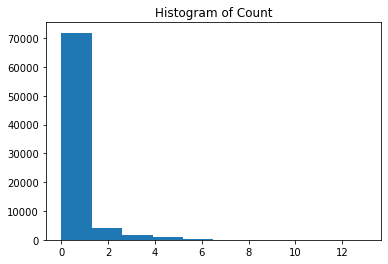

In [5]:
plt.hist(data['count'])
plt.title('Histogram of Count');

print(data[data['count'] == 0]['count'].shape)

In [6]:
# NANs in D / R
data = data.fillna(0)
# low / medium / high
data['Precipitation'] = pd.cut(data['Precipitation'],3,labels=[1,2,3])
data = data.drop(['DBT','utcivar2','utcivar3','DateTime'],axis=1)
X = data.drop('count',axis=1)
y = data['count']
X_train, X_test, y_train, y_test  = train_test_split(X,y,train_size = .7,random_state = 44)

In [7]:
model = RandomForestRegressor()
model.fit(X_train,y_train)

RandomForestRegressor()

In [8]:
trainr2 = model.score(X_train,y_train)
testr2 = model.score(X_test,y_test)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_mse = mean_squared_error(y_train,train_pred)
test_mse = mean_squared_error(y_test,test_pred)

print(f"Train MSE: {round(train_mse,3)} Train R2: {round(trainr2,3)}")
print(f"Test MSE: {round(test_mse,3)} Test R2: {round(testr2,3)}")

Train MSE: 0.215 Train R2: 0.733
Test MSE: 0.78 Test R2: 0.011


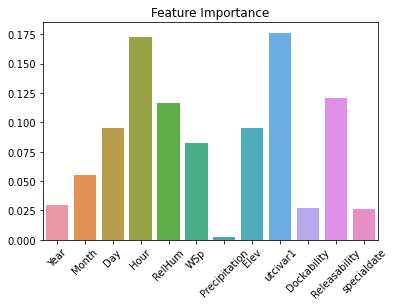

In [9]:
features = list(X.columns)
values = list(model.feature_importances_)

sns.barplot(features, values)
plt.xticks(rotation=45);
plt.title('Feature Importance');

In [10]:
model = LinearRegression().fit(X_train,y_train)

In [11]:
trainr2 = model.score(X_train,y_train)
testr2 = model.score(X_test,y_test)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_mse = mean_squared_error(y_train,train_pred)
test_mse = mean_squared_error(y_test,test_pred)

print(f"Train MSE: {round(train_mse,3)} Train R2: {round(trainr2,3)}")
print(f"Test MSE: {round(test_mse,3)} Test R2: {round(testr2,3)}")

Train MSE: 0.725 Train R2: 0.101
Test MSE: 0.71 Test R2: 0.1


In [12]:
data = get_data()
# NANs in D / R
data = data.fillna(0)
# low / medium / high
data['Precipitation'] = pd.cut(data['Precipitation'],3,labels=[1,2,3])
data = data.drop(['DBT','utcivar2','utcivar3','DateTime'],axis=1)
data['count'] = (data['count'] == 0) * 1
X = data.drop('count',axis=1)
y = data['count']
X_train, X_test, y_train, y_test  = train_test_split(X,y,train_size = .7,random_state = 44)

cols = X_train.columns

# Fit and transform features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Convert from numpy to df
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# Reset column names
X_train.columns = cols
X_test.columns = cols 

In [13]:
model = LogisticRegression(max_iter=10000).fit(X_train,y_train)

In [14]:
trainr2 = model.score(X_train,y_train)
testr2 = model.score(X_test,y_test)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_score = accuracy_score(y_train,train_pred)
test_score = accuracy_score(y_test,test_pred)

print(f"Train Acc Score: {round(train_score,3)} Train R2: {round(trainr2,3)}")
print(f"Test Acc Score: {round(test_score,3)} Test R2: {round(testr2,3)}")

Train Acc Score: 0.757 Train R2: 0.757
Test Acc Score: 0.752 Test R2: 0.752


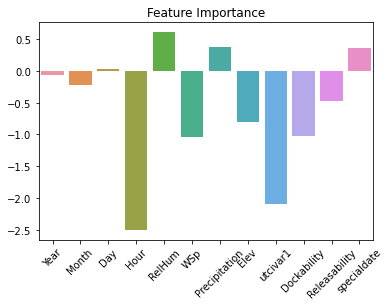

In [15]:
features = list(X.columns)
values = list(model.coef_[0])

sns.barplot(features, values)
plt.xticks(rotation=45);
plt.title('Feature Importance');

In [16]:
model = RandomForestClassifier()
model.fit(X_train,y_train)

RandomForestClassifier()

In [17]:
trainr2 = model.score(X_train,y_train)
testr2 = model.score(X_test,y_test)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_score = accuracy_score(y_train,train_pred)
test_score = accuracy_score(y_test,test_pred)

print(f"Train Acc Score: {round(train_score,3)} Train R2: {round(trainr2,3)}")
print(f"Test Acc Score: {round(test_score,3)} Test R2: {round(testr2,3)}")

Train Acc Score: 0.942 Train R2: 0.942
Test Acc Score: 0.763 Test R2: 0.763
